https://colab.research.google.com/github/KiweeEu/transfer-learning-demo/blob/master/TransferLearning.ipynb

https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html

https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB4

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
import tensorflow_datasets as tfds

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TF version: 2.12.0
Hub version: 0.13.0
GPU is available


In [2]:


module_selection = ("inception_v3", 299) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 16 #@param {type:"integer"}
     


Using https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4 with input size (299, 299)


In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name="oxford_flowers102",
    split=['test', 'validation', 'train'],
    with_info=True,
    as_supervised=True,
    batch_size=32
)

In [4]:
IMAG_SIZE = 224 # All images will be resized to 224x224
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMAG_SIZE, IMAG_SIZE))
  return  image, label

In [5]:
train = raw_train.map(normalize_img)
validation = raw_validation.map(normalize_img)
test = raw_test.map(normalize_img)
     

In [7]:
# print("Building model with", MODULE_HANDLE)
# conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAG_SIZE, IMAG_SIZE,3))

!pip install efficientnet==1.1.0
from efficientnet import tfkeras as efficientnet

base_model = efficientnet.EfficientNetB4(
    weights='noisy-student',
    pooling='avg',
    include_top=False,
    input_shape=(IMAG_SIZE,IMAG_SIZE,3)
)

# efficientnet = tf.keras.applications.EfficientNetV2S(include_top=False,input_shape=(IMAG_SIZE,IMAG_SIZE,3),weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1072, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=metadata.features["label"].num_classes)
])

model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
71678424/71678424 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b4 (Functional  (None, 1792)             17673816  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 4096)              7344128   
                                                                 
 dense_1 (Dense)             (None, 1072)              4391984   
                                                                 
 dropout (Dropout)           (None, 1072)              0         
                        

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

earlystopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
     

In [9]:
train = train.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat().shuffle(512)
validation = validation.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat()

In [11]:
steps_per_epoch = metadata.splits["train"].num_examples / BATCH_SIZE 
validation_steps = metadata.splits["validation"].num_examples / BATCH_SIZE
EPOCHS = 15
hist = model.fit(
    x=train,
    epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
    validation_data=validation,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback],
    verbose=1).history

Epoch 1/15
63/63 [==============================] - 56s 211ms/step - loss: 1.0599 - accuracy: 0.6855 - val_loss: 1.0231 - val_accuracy: 0.7188
Epoch 2/15
63/63 [==============================] - 12s 190ms/step - loss: 0.8734 - accuracy: 0.7412 - val_loss: 1.0173 - val_accuracy: 0.7168
Epoch 3/15
63/63 [==============================] - 12s 188ms/step - loss: 0.9373 - accuracy: 0.7227 - val_loss: 0.9739 - val_accuracy: 0.7070
Epoch 4/15
63/63 [==============================] - 13s 204ms/step - loss: 0.9216 - accuracy: 0.7383 - val_loss: 0.8600 - val_accuracy: 0.7373
Epoch 5/15
63/63 [==============================] - 16s 247ms/step - loss: 0.8997 - accuracy: 0.7324 - val_loss: 0.9344 - val_accuracy: 0.7295
Epoch 6/15
63/63 [==============================] - 12s 189ms/step - loss: 0.8610 - accuracy: 0.7402 - val_loss: 1.0093 - val_accuracy: 0.7061
Epoch 7/15
63/63 [==============================] - 17s 269ms/step - loss: 0.8935 - accuracy: 0.7266 - val_loss: 0.8122 - val_accuracy: 0.7725

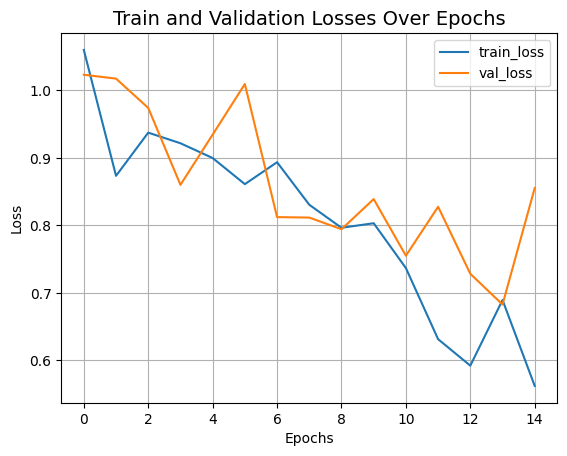

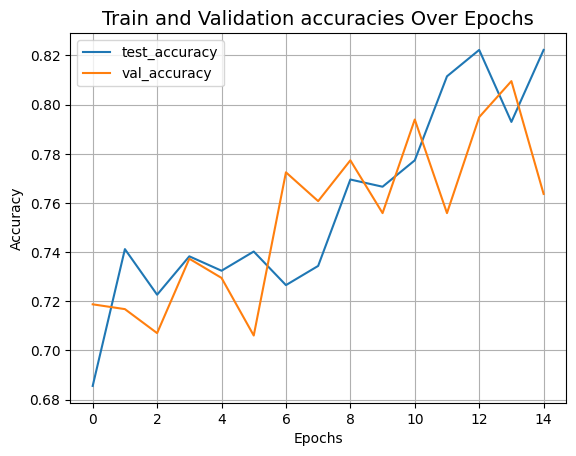

In [12]:
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(hist["accuracy"], label="test_accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation accuracies Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [13]:
image_batch = []
label_batch = []
image_batch, label_batch = next(iter(test))

t = list(test.as_numpy_iterator())

for i in range(len(test)-1):
    image_batch = np.append(image_batch, t[i+1][0], axis=0)
    label_batch = np.append(label_batch, t[i+1][1], axis=0)


image_batch = image_batch
label_batch = label_batch

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
# predicted_class_names = class_names[predicted_ids]
# print(predicted_class_names)

32/32 [==============================] - 9s 163ms/step


In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = predicted_ids#np.argmax(probs, axis=1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = label_batch#np.argmax(y_test, axis=1)

# Obter os nomes das classes
# class_names = list(validgen.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

Precisão: 0.7333333333333333


In [15]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Calcular a precisão, recall e F1-score para cada classe
report = classification_report(true_classes, predicted_classes, target_names=np.array(metadata.features['label'].names))

# Exibir o relatório de classificação
print(report)

                           precision    recall  f1-score   support

            pink primrose       1.00      0.20      0.33        10
hard-leaved pocket orchid       1.00      1.00      1.00        10
         canterbury bells       0.00      0.00      0.00        10
                sweet pea       1.00      0.10      0.18        10
         english marigold       0.83      1.00      0.91        10
               tiger lily       1.00      0.50      0.67        10
              moon orchid       1.00      0.50      0.67        10
         bird of paradise       0.91      1.00      0.95        10
                monkshood       0.83      0.50      0.62        10
            globe thistle       1.00      0.80      0.89        10
               snapdragon       0.83      0.50      0.62        10
              colt's foot       0.88      0.70      0.78        10
              king protea       1.00      0.70      0.82        10
            spear thistle       0.90      0.90      0.90     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
